# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [21]:
import graphlab
import numpy as np


# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = graphlab.SFrame('/Users/Sajjad/Downloads/kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 1.594901     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 1.663532     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 1.749233     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 1.820618     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 1.880697     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 1.961504     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [99]:
def get_nz(model):
    a = model.get('coefficients')
    a = a[a['value'] !=0]
    return a
    
get_nz(model_all)

name,index,value,stderr
(intercept),None,274873.05595,None
bathrooms,None,8468.53108691,None
sqft_living,None,24.4207209824,None
sqft_living_sqrt,None,350.060553386,None
grade,None,842.068034898,None
sqft_above,None,20.0247224171,None


In [176]:
print(model_all.get('coefficients').print_rows(num_rows=18))


+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [15]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [114]:
def loo(train,valid,output, l1_penalty,l2,feature):
    next_mse = None
    model_list = []
    model = graphlab.linear_regression.create(train,
                                                      features = feature,
                                                      target=output, 
                                                        l2_penalty=l2,
                                                        l1_penalty =l1_penalty, 
                                                        validation_set=None,
                                                        verbose=False
                                                        )
    model_list.append(model)
    # predict on validation set 
    y_test_predicted = model.predict(valid)
    # compute squared error
    next_mse = ((y_test_predicted-valid[output])**2).sum()
    return next_mse

In [177]:
l1_values = np.logspace(1, 7, num=33)
mse_list = graphlab.SFrame()
error = []
l1_list = []
for l1 in l1_values:
    aa = loo(training,validation,'price',l1,0,all_features)
    error.append(aa)
    l1_list.append(l1)
mse_list['l1_val'] = l1_list
mse_list['error'] = error

mse_list
a = mse_list['error']
a = min(a)
b = mse_list[mse_list['error'] == a]
b

l1_val,error
10.0,6.25766285142e+14


*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [180]:
bestl1_model = graphlab.linear_regression.create(training,
                                                      features = all_features,
                                                      target='price', 
                                                        l2_penalty=0,
                                                        l1_penalty =10, 
                                                        validation_set=None,
                                                        verbose=False
                                                        )
#bestl1_model.get('coefficients')
#.print_rows(num_rows=18)
print(bestl1_model.get('coefficients').print_rows(num_rows=18))

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [ ]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [154]:
l1_penalty_values = np.logspace(8, 10, num=20)
mse_nz_list = graphlab.SFrame()
nz_num = []
l1_list = []
next_mse = None
model_list = []
max_nonzeros = 7
l1_penalties_max, l1_penalties_min = list(), list()
for l1 in l1_penalty_values:
    
    model = graphlab.linear_regression.create(training,
                                                      features = all_features,
                                                      target='price', 
                                                        l2_penalty=0,
                                                        l1_penalty =l1, 
                                                        validation_set=None,
                                                        verbose=False
                                                        )
    a = get_nz(model)
    ab = len(a['value'])-1
    if ab > max_nonzeros:
        #print "max", l1_penalty
        l1_penalties_max.append(l1)
    if ab < max_nonzeros:
        #print "min", l1_penalty
        l1_penalties_min.append(l1)
    
    nz_num.append(ab)
    l1_list.append(l1)
mse_nz_list['l1_val'] = l1_list
mse_nz_list['non_z'] = nz_num



+---------------+-------+
|     l1_val    | non_z |
+---------------+-------+
|  100000000.0  |   17  |
|  127427498.57 |   17  |
| 162377673.919 |   17  |
| 206913808.111 |   17  |
| 263665089.873 |   16  |
| 335981828.628 |   16  |
| 428133239.872 |   16  |
| 545559478.117 |   16  |
| 695192796.178 |   16  |
|  885866790.41 |   15  |
+---------------+-------+
[20 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


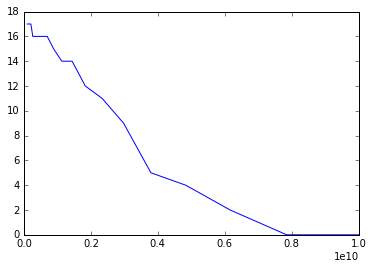

In [152]:
% matplotlib inline
plt.plot(mse_nz_list['l1_val'],mse_nz_list['non_z'],'-')
print(mse_nz_list)


Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

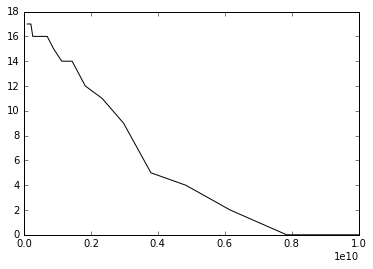

In [155]:
mse_list
plt.plot(mse_nz_list['l1_val'],mse_nz_list['non_z'],'k-')

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [156]:
l1_nz = graphlab.SFrame()
l1_nz['l1'] = l1_penalty_values


In [159]:
l1_penalty_min = max(l1_penalties_max)
l1_penalty_max = min(l1_penalties_min)
print(l1_penalty_min)
print(l1_penalty_max)

2976351441.63
3792690190.73


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [162]:
l1_penalty_values2 = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [167]:

mse_list2 = graphlab.SFrame()
error2 = []
l1_list2 = []
for l1 in l1_penalty_values2:
    aa = loo(training,validation,'price',l1,0,all_features)
    error2.append(aa)
    l1_list2.append(l1)
mse_list2['l1_val'] = l1_list2
mse_list2['error'] = error2


a2 = mse_list2['error']
a2 = min(a2)
b2 = mse_list2[mse_list2['error'] == a2]
b2

l1_val,error
2976351441.63,9.66925692362e+14


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [173]:
model4 = model = graphlab.linear_regression.create(training,
                                                      features = all_features,
                                                      target='price', 
                                                        l2_penalty=0,
                                                        l1_penalty =2976351441.63, 
                                                        validation_set=None,
                                                        verbose=False
                                                        )
ass =get_nz(model4)
ass

name,index,value,stderr
(intercept),None,196100.937806,None
bedrooms,None,2181.57432107,None
bathrooms,None,17962.6966612,None
sqft_living,None,34.1424656512,None
sqft_living_sqrt,None,789.319789078,None
floors,None,3665.9308176,None
view,None,11333.8410308,None
grade,None,3578.90040044,None
sqft_above,None,32.7432013718,None
sqft_basement,None,12.7953811359,None


In [174]:
len(ass)-1

9